## 1. Transformer 구조
---
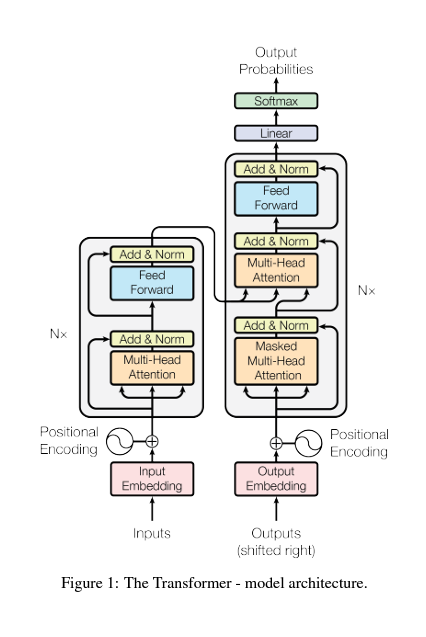


## 2. Transformer와 Encoder, Decoder 
---
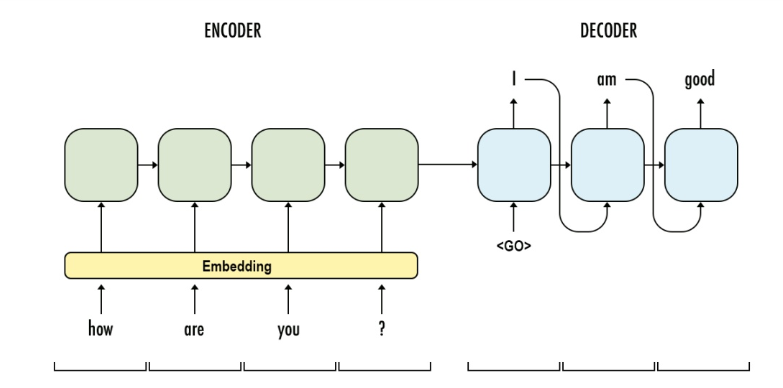


- 번역기는 **인코더와 디코더** 두 가지 아키텍처로 구성돼 있다.
- 인코더에 입력 문장이 들어가고, 디코더는 이에 상응하는 출력 문장을 생성한다.

> 훈련 데이터셋의 구성(번역)
    
* 입력 문장 : '저는 학생입니다.'
* 출력 문장 : 'I am a student'


- 동일 방식으로 질문 문장과 대답 데이터로 인코더와 디코더를 학습시키면 챗봇도 만들 수 있다.

### 트랜스포머의 인코더와 디코더

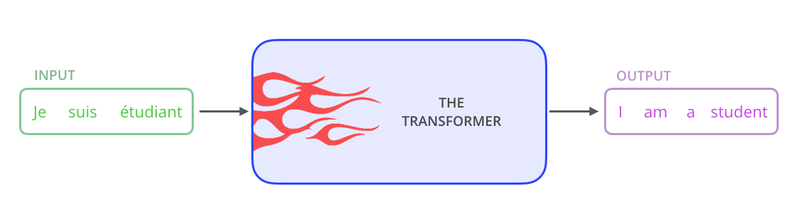

- 트랜스포머로 이루어져있는 번역기도 인코더-디코더 구성을 지니고 있다.
- 위 그림의 블랙박스로 가려진 내부를 열어보면 아래 사진과 같다.

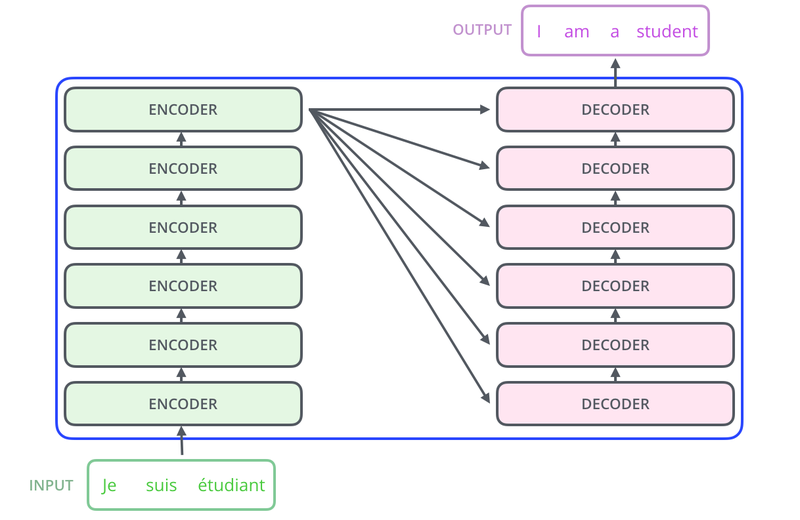

1. 입력 문장은 누적해 쌓아올린 인코더의 층을 통해서 정보를 뽑아낸다.
2. 디코더는 누적해 쌓아 올린 디코더의 층을 통해서 출력 문장의 단어를 하나씩 만들어가는 구조를 갖고 있다.

    - 인코더는 입력 문장을 임베딩하고 문장의 의미를 파악하여 디코더에 전달한다. 
    - 디코더는 인코더에서 전달 받은 정보를 기반으로 문장을 생성한다.

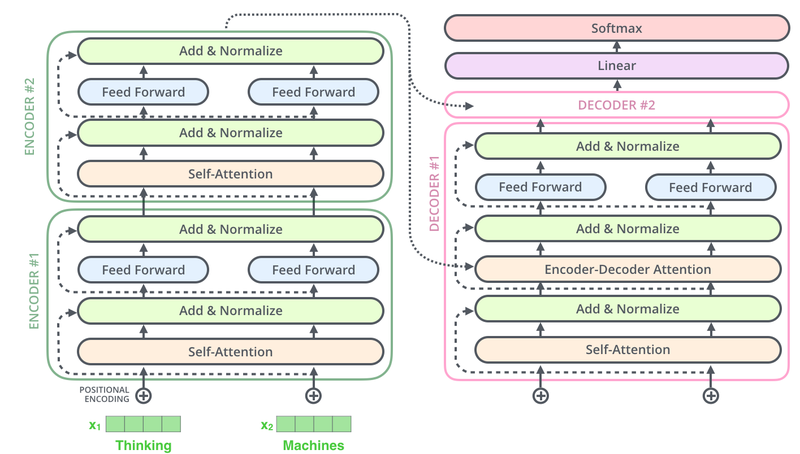


<br><br>

## 3. Transformer 입력 이해하기
---
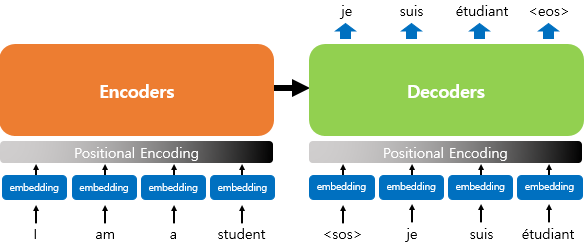

- Transformer도 입력으로 임베딩 벡터로 변환하는 벡터와 과정을 거친다.
- 기존 RNN과 다른 점은, Transformer의 입력 데이터 처리에는 임베딩 벡터에 어떤 값을 더해준 뒤에 입력으로 사용한다는 점이다.
<br><br>
> **Positional Encoding**

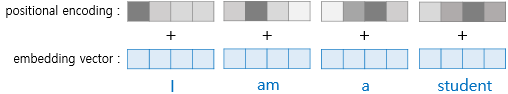

- Transformer는 입력을 받을 때, 문장에 있는 단어들을 1개씩 받는 것이 아니라, **모든 단어를 한꺼번에 입력으로 받기 때문이다.**
- RNN은 어차피 문장의 단어들이 어순대로 모델에 입력되기에 모델에게 따로 어순을 알려줄 필요가 없었으나, 한꺼번에 문장 단위로 입력받는 Transformer는 'I ate lunch'와 'lunch ate I'를 구분할 수 없을지도 모른다.
    - 그래서 같은 단어 일지라도 그 단어가 문장의 몇번째 어순으로 입력되었는지를 모델에 추가로 알려주기 위해 **단어의 임베딩 벡터에 위치정보를 가진 벡터 값을 더해서 모델의 입력으로 삼는다.**
    
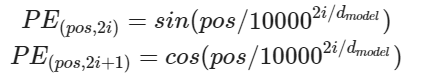

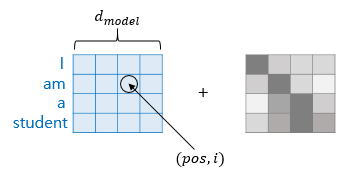

- Positional Encoding은 Sin과 Cos 함수의 그래프를 상기해보면 요동치는 값의 형태를 생각해볼 수 있다.
- Trnasfomer는 Sin함수와 Cos함수의 값을 임베딩 벡터에 더해줌으로써 단어의 순서 정보를 더해 준다.

$$d_(model) : 임베딩 벡터의 차원$$
$$pos : 입력 문장에서의 임베딩 벡터의 위치$$
$$i : 임베딩 벡터 내의 차원의 인덱스$$

- 이렇게 임베딩 행렬과 포지셔널 행렬을 더해서 각 단어 벡터에 위치 정보를 더해줍니다.

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

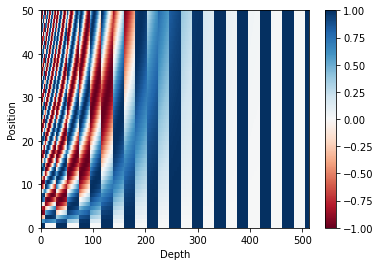

In [4]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

**임베딩 벡터의 차원이 256이고 최대 문장의 길이가 30인 텍스트를 입력으로 하는 트랜스포머를 구현한다고 하였을 때, 적절한 포지셔널 인코딩 행렬은 (30, 256)으로 나타낼 수 있다.**

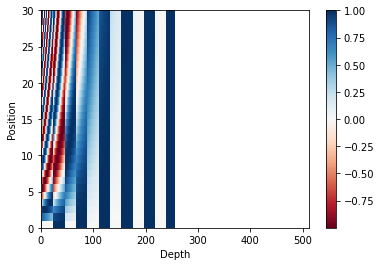

In [6]:
sample_pos_encoding = PositionalEncoding(30, 256)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## 4. Attention 이란
---
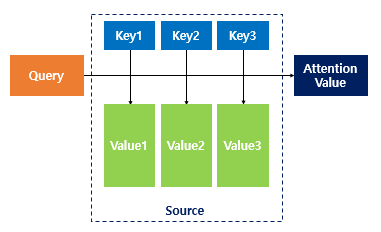
<br>
1. 어텐션 함수는 주어진 '쿼리(Query)'에 대해서 모든 '키(Key)'와의 유사도를 각각 구한다.
2. 구한 키(Key)와 맵핑되어있는 각각의 값(Value)에 반영한다. 
3. 그리고 유사도가 반영된 값(Value)를 모두 더해서 뭉쳐준 것을 **Attention Value라고 한다.**
---
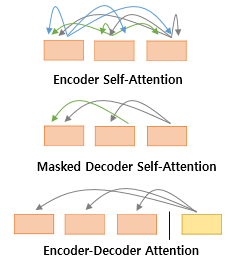

- Transformer는 총 세 가지의 Attention을 사용한다.
    1. 첫 번째 그림은 Encoder Self-Attention
    2. 두 번째 그림은 Decoder Self-Attention
    3. 세 번째 그림은 Encoder-Decoder Attention
---
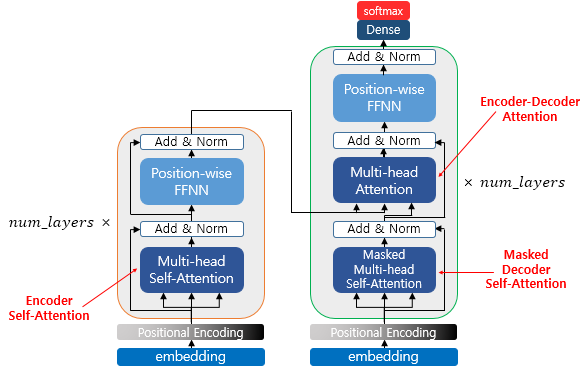

- 트랜스포머의 어텐션 함수에 사용되는 **쿼리(Query), 키(Key), 밸류(Value) 는 기본적으로 '단어 (정보를 함축한) 벡터'**이다.
    - 단어 벡터란 초기 입력으로 사용되었던 임베딩 벡터가 아니고, 트랜스포머의 여러 연산을 거친 후의 단어 벡터이다.
<br><br>
- **인코더 셀프 어텐션** : 인코더의 입력으로 들어간 문장 내 단어들이 서로 유사도를 구한다.
- **디코더 셀프 어텐션** : 단어를 1개씩 생성하는 디코더가 이미 생성된 앞 단어들과의 유사도를 구한다.
- **인코더-디코더 어텐션** : 디코더가 잘! 예측하기 위해서 인코더에 입력된 단어들과 유사도를 구한다.
---
### Self-Attention
-  유사도를 구하는 대상이 다른 문장의 단어가 아니라 현재 문장 내의 단어들이 서로 유사도를 구하는 경우를 말한다.

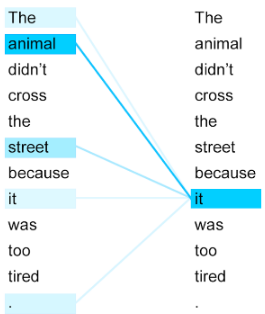

- 다른 어텐션은 다른 문장의 단어가 아닌 현재 문장 내의 단어들의 유사도를 구하는 것이다. 
- 인코더-디코더 어텐션은 인코더에 입력된 단어들과 디코더에서 생성된 문장의 단어들과의 유사도를 구한다.



## 5. Scaled-Dot-Production Attention
---
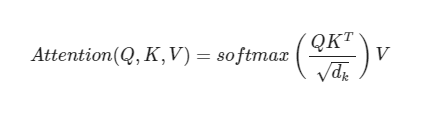

- Q,K,V는 각각 쿼리(Query), 키(Key), 값(Value)을 나타낸다.

1. Q, K, V는 단어 벡터를 행으로 하는 문장 행렬이다.
2. 벡터의 내적(Dot Product)은 벡터의 유사도를 의미한다.
3. 특정 값을 분모로 사용하는 것은 값의 크기를 조절하는 스케일링을 위함이다.

---
##### 1. Q와 K의 전치행렬을 곱해줌
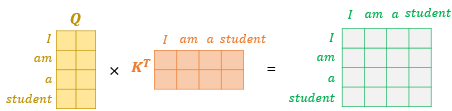
- 초록색 행렬은 각 단어 벡터의 유사도가 모두 기록된 유사도 행렬을 의미한다.
    - 예를 들어서, 'am' 행과 'student'열의 값을 Q 행렬의 'am' 벡터와 K 행렬의 'student' 벡터의 내적값을 의미합니다.
<br>

##### 2. 유사도 값을 스케일링 해주기 위해 행렬 전체를 특정 값으로 나눠줌
##### 3. 유사도를 0과 1 사이의 값으로 Normalize해주기 위해 Softmax 함수 사용
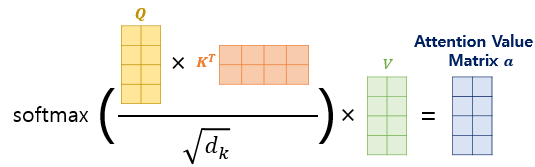

- 여기까지가 Q와 K의 유사도를 구하는 과정이고 여기에 문장행렬 V를 곱하면 Attention Value를 얻는다.

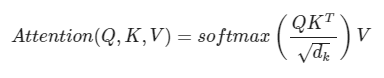

- 이 수식은 내적(dot product)을 통해 단어 벡터 간 유사도를 구한 후에, 특정 값을 분모로 나눠주는 방식으로 Q와 K의 유사도를 구하였다고 하여 **스케일드 닷 프로덕트 어텐션(Scaled Dot Product Attention)** 이라고 한다. 
- 유사도를 구하는 방법이 **스케일드 닷 프로덕트(scaled dot product)**였기 때문에 이런 이름이 붙은 것이지요.

만약에 분모에 특정 값을 나눠주는 부분을 사용하지 않았다면 어텐션의 이름은 무엇일까요? 그 어텐션은 당연히 닷 프로덕트 어텐션(dot product attention) 이라고 부릅니다.

In [7]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

## 6. MultiHead Attention
---
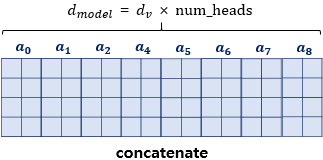

- Transformer에서 num_heads라는 변수는 병렬적으로 몇 개의 어텐션 연산을 수행할지를 결정하는 파라미터이다.
- 앞서 포지셔널 인코딩에서 d_model은 임베딩 벡터의 차원이라고 했다.
- 위의 그림은 num_heads가 8개인 경우인데, 다시 concatenate하면서 열의 크기가 d_model이 된다.
- 8개의 머리는 각각 다른 관점에서 어텐션을 수행하므로 한 번의 어텐션만 수행했다면 놓칠 수도 있던 정보를 캐치할 수 있다.

In [40]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size) 

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

## 6. Masking
---
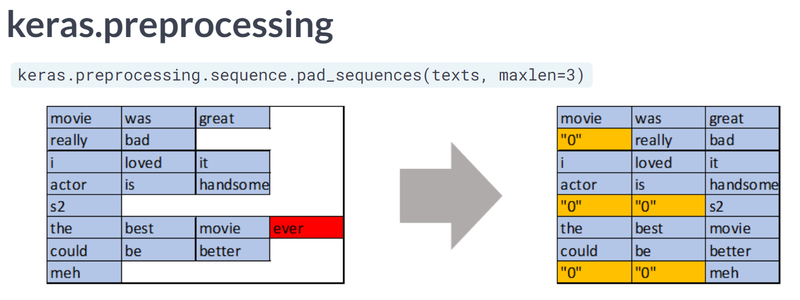

패딩: 문장의 길이가 서로 다를 때, 모든 문장의 길이를 동일하게 해주는 과정에서 **정해준 길이보다 짧은 문장의 경우 숫자 0을 채워서 문장의 길이를 맞춰주는 전처리 방법이다.**

In [9]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [10]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


### Look-Ahead Masking, 다음 단어 가리기

- RNN의 경우, Step이라는 개념이 존재해서 step마다 단어가 순서대로 들어간다.
- 반면, Transformer의 경우 문장 행렬을 만들어 한 번에 행렬 형태로 입력으로 들어간다는 특징이 존재한다. **(이 특징으로 인해 Masking이 필요하다)**

    - 전체 문장이 문장 행렬로 들어가기 때문에 위치와 상관없이 모든 단어를 참고해서 다음 단어를 예측할 수 있지만, 이전 단어를 바탕으로 다음 단어를 예측하는 것이 필요하다.
    - 이러한 문제를 해결하기 위한 것이 **Look-Ahead Masking**기법이다.

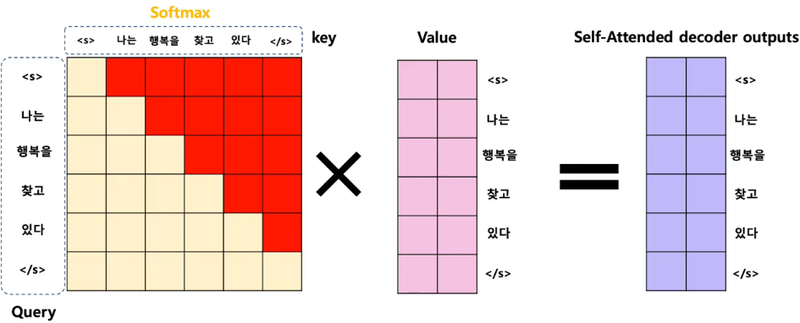

- 위 그림에서 빨간색으로 색칠된 부분은 마스킹을 표현하고 있는 부분이다.

In [11]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [12]:
print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [13]:
print(create_look_ahead_mask(tf.constant([[0, 5, 1, 5, 5]])))

tf.Tensor(
[[[[1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 0. 1. 1.]
   [1. 0. 0. 0. 1.]
   [1. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


- 1로 되어 있는 값이 마스킹 된 것이다.
- 즉 다음 단어를 알 수 없도록 마스킹을 통해 지운것이다.
- 데이터에 \<PAD>가 있는 경우 이 또한 동일하게 패딩해주어야 하므로 1로 마스킹된 것을 볼 수 있다.

## 8. Encoder
---
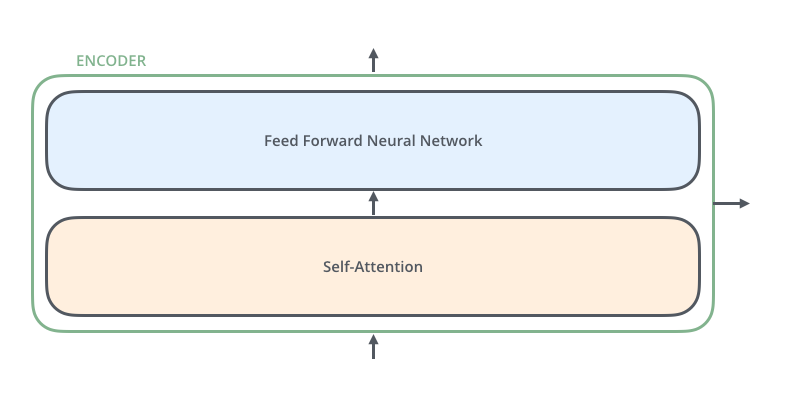
- 하나의 인코더 층은 크게 총 2개의 Sublayer로 나뉜다.
- Self-Attention, Feed Forward Neural Network이다.

In [41]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

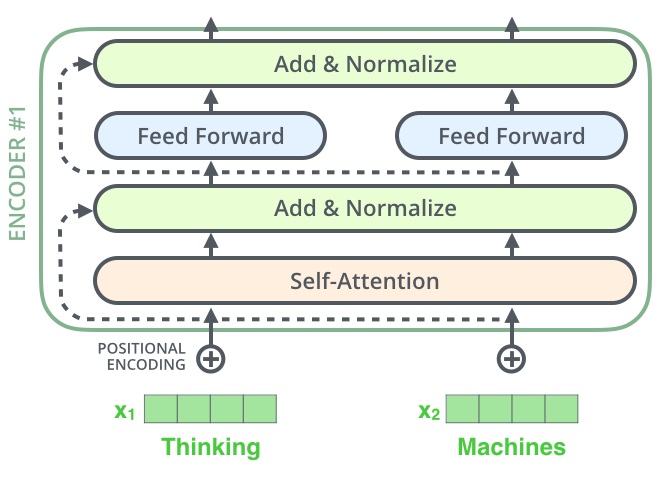

---

### 인코더 층을 쌓아서 인코더 만들기
- 이렇게 구현한 인코더 층을 Embedding Layer와 Positional Encoding을 연결하고 원하는 만큼 인코더 층을 쌓음으로써 트랜스포머의 인코더가 완성된다.
- 인코더와 디코더 내부에서는 각 서브 층 이후에 훈련을 돕는 Layer Normalization이라는 테크닉이 사용되었는데. 위 그림에서는 Normalize라고 표시된 부분에 해당한다.

In [42]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

## 9. Decoder
---

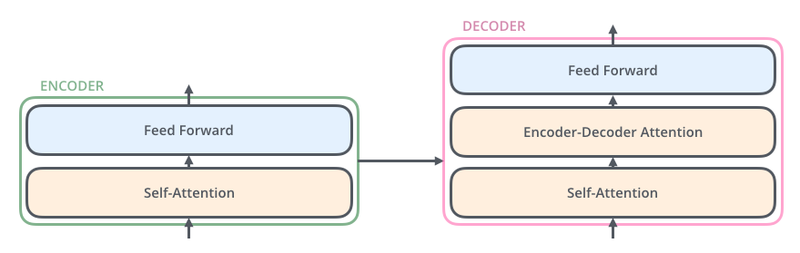
- Encoder와 달리 2개가 아닌 3개의 층으로 구성되어 있다.
- Self-Attention, Encoder-Decoder Attention, Feed Forward
- Encoder-Decoder Attention은 Query가 Decoder의 벡터인 반면, Key와 Value가 Encoder의 벡터라는 특징이 존재한다.
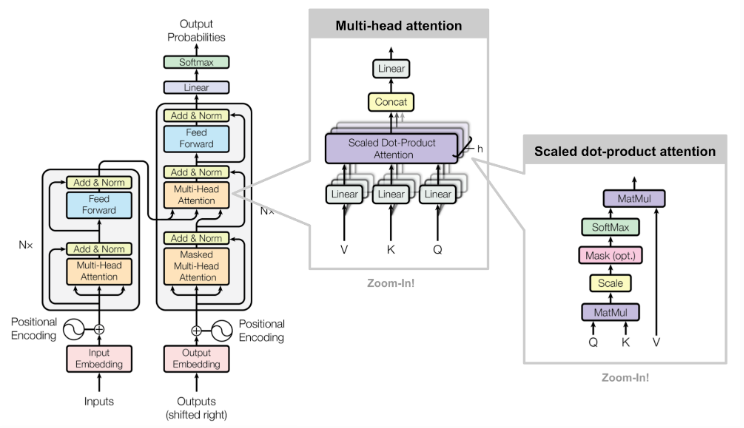

In [43]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

- 동일하게 Embedding Layer와 Positional Encoding을 연결하고 원하는 만큼 쌓아서 완성한다.

In [44]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

## 10. Chatbot의 병렬 데이터 받아오기
- Cornell Movie-Dialogs Corpus라는 영화 및 TV 프로그램에서 사용되었던 대화의 쌍으로 구성된 데이터셋을 사용

In [22]:
path_to_zip = tf.keras.utils.get_file(
    'cornell_movie_dialogs.zip',
    origin='http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip',
    extract=True)

path_to_dataset = os.path.join(
    os.path.dirname(path_to_zip), "cornell movie-dialogs corpus")

path_to_movie_lines = os.path.join(path_to_dataset, 'movie_lines.txt')
path_to_movie_conversations = os.path.join(path_to_dataset,'movie_conversations.txt')

In [23]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = 50000
print(MAX_SAMPLES)

50000


- 전처리에서는 정규 표현식을 사용해서 구두점(puctuation)을 제거하여 단어를 토크나이징(tokenizing)하는 일에 방해가 되지 않도록 정제하는 것을 목표로 한다.

In [24]:
# 전처리 함수
def preprocess_sentence(sentence):
  # 입력받은 sentence를 소문자로 변경하고 양쪽 공백을 제거
  sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  sentence = re.sub(r'[^a-zA-Z.?!,\s]', ' ', sentence)
  sentence = sentence.strip()
  return sentence

In [25]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_conversations():
  id2line = {}
  with open(path_to_movie_lines, errors='ignore') as file:
    lines = file.readlines()
  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    id2line[parts[0]] = parts[4]

  inputs, outputs = [], []
  with open(path_to_movie_conversations, 'r') as file:
    lines = file.readlines()

  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    conversation = [line[1:-1] for line in parts[3][1:-1].split(', ')]

    for i in range(len(conversation) - 1):
      # 전처리 함수를 질문에 해당되는 inputs와 답변에 해당되는 outputs에 적용.
      inputs.append(preprocess_sentence(id2line[conversation[i]]))
      outputs.append(preprocess_sentence(id2line[conversation[i + 1]]))

      if len(inputs) >= MAX_SAMPLES:
        return inputs, outputs
  return inputs, outputs

In [26]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 50000
전체 샘플 수 : 50000


In [27]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: she s not a . . .
전처리 후의 22번째 답변 샘플: lesbian ? no . i found a picture of jared leto in one of her drawers , so i m pretty sure she s not harboring same sex tendencies .


- ?나 .과 같은 구두점들이 단어들과 분리되어 단어와 구두점 사이에는 공백이 추가된 것을 확인할 수 있다. 
- 이렇게 함으로써 단어를 토크나이징 하는 과정에서 구두점과 붙어있던 단어들을 하나의 단어로 인식하는 것을 방지할 수 있다.

## 11. 병렬 데이터 전처리하기

1. TensorFlow Datasets SubwordTextEncoder 를 토크나이저로 사용한다.  단어보다 더 작은 단위인 Subword를 기준으로 토크나이징하고,  각 토큰을 고유한 정수로 인코딩 한다.
2. 각 문장을 토큰화하고 각 문장의 시작과 끝을 나타내는 START_TOKEN 및 END_TOKEN을 추가한다.
3. 최대 길이 MAX_LENGTH 인 40을 넘는 문장들은 필터링한다.
4. MAX_LENGTH보다 길이가 짧은 문장들은 40에 맞도록 패딩 한다.

### 11-1. 단어장 만들기

In [28]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [30]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [31]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8336]
END_TOKEN의 번호 : [8337]


In [32]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8338


### 11-2. 각 단어를 고유한 정수로 인코딩 & 패딩
- tokenizer.encode()로 각 단어를 정수로 변환할 수 있고 또는 tokenizer.decode()를 통해 정수 시퀀스를 단어 시퀀스로 변환할 수 있다.

In [33]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [62, 8, 36, 8177, 50]
정수 인코딩 후의 21번째 답변 샘플: [7835, 1126, 19, 59, 2, 4, 340, 10, 1682, 14, 1114, 749, 2607, 272, 17, 74, 14, 109, 2162, 864, 3, 63, 4, 23, 357, 208, 62, 8, 36, 901, 2310, 8112, 347, 1040, 5187, 4232, 335, 1]


In [34]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [35]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

In [36]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8338
필터링 후의 질문 샘플 개수: 43982
필터링 후의 답변 샘플 개수: 43982


### 11-3. 교사 강요 (Teacher Forcing) 사용하기

- **tf.data.Dataset API** : 훈련 프로세스의 속도가 빨라지도록 입력 파이프라인을 구축하는 API
- 이 API를 적극 사용하기 위해서 질문과 답변의 쌍을 tf.data.Dataset의 입력으로 넣어주는 작업을 한다.
- 이때, 디코더의 입력과 실제값(레이블)을 정의해주기 위해서는 교사강요(Teacher Forcing) 이라는 언어 모델의 훈련 기법을 이해해야만 한다.


- **교사 강요(teacher forcing)란**, 테스트 과정에서 t 시점의 출력이 t+1 시점의 입력으로 사용되는 RNN 모델을 훈련시킬 때 사용하는 훈련 기법입니다. 훈련할 때 교사 강요를 사용할 경우, 모델이 t 시점에서 예측한 값을 t+1 시점에 입력으로 사용하지 않고, t 시점의 레이블. 즉, 실제 알고있는 정답을 t+1 시점의 입력으로 사용한다.
---
샘플 : '\<START_TOKEN> I AM A STUDENT \<END_TOKEN> \<PAD> \<PAD> \<PAD> \<PAD>'

**교사강요 적용시**

입력 : \<START_TOKEN> I AM A STUDENT \<END_TOKEN> \<PAD> \<PAD> \<PAD> <br>
레이블 : I AM A STUDENT \<END_TOKEN> \<PAD> \<PAD> \<PAD> \<PAD>
    
---
<br>
- 이전 자신의 출력이 현재 자신의 상태를 결정하는 모델을 자기회귀 모델(auto-regressive model, AR)이라고 하는데, 교사 강요가 이에 해당한다.
- Transformer도 교사 강요를 적용한다.
<br>

교사 강요를 위해서 answers[:, :-1]를 디코더의 입력값, answers[:, 1:]를 디코더의 레이블로 사용한다.

In [37]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

## 12. 모델 정의 및 학습하기
---


In [38]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

### 12-1. 모델 생성

In [45]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3188736     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

### 12-2. 손실 함수

In [50]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

### 12-3. 커스텀 된 학습률
---

**커스텀 학습률 스케줄링** <br>
- 딥러닝 모델학습 시 learning rate는 매우 중요한 하이퍼파라미터 
- 최근에는 모델학습 초기에 learning rate를 급격히 높였다가, 이후 train step이 진행됨에 따라 서서히 낮추어 가면서 안정적으로 수렴하게 하는 기법을 사용

---

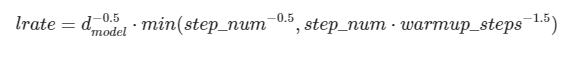

In [47]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

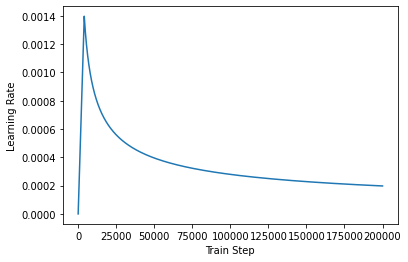

In [48]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### 12-4. 모델 컴파일

In [51]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

### 12-5. 훈련하기

In [52]:
EPOCHS = 10
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/10
688/688 [==============================] - 56s 57ms/step - loss: 2.1273 - accuracy: 0.0418
Epoch 2/10
688/688 [==============================] - 38s 56ms/step - loss: 1.5111 - accuracy: 0.0786
Epoch 3/10
688/688 [==============================] - 39s 56ms/step - loss: 1.4045 - accuracy: 0.0857
Epoch 4/10
688/688 [==============================] - 38s 56ms/step - loss: 1.3436 - accuracy: 0.0902
Epoch 5/10
688/688 [==============================] - 38s 56ms/step - loss: 1.2911 - accuracy: 0.0946
Epoch 6/10
688/688 [==============================] - 38s 56ms/step - loss: 1.2438 - accuracy: 0.0981
Epoch 7/10
688/688 [==============================] - 38s 56ms/step - loss: 1.1897 - accuracy: 0.1022
Epoch 8/10
688/688 [==============================] - 38s 56ms/step - loss: 1.1283 - accuracy: 0.1076
Epoch 9/10
688/688 [==============================] - 38s 56ms/step - loss: 1.0710 - accuracy: 0.1132
Epoch 10/10
688/688 [==============================] - 39s 56ms/step - loss: 1.018

## 13. Chatbot 테스트하기
---
1. 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.
2. 입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가한다.
3. 패딩 마스킹과 룩 어헤드 마스킹을 계산한다.
4. 디코더는 입력 시퀀스로부터 다음 단어를 예측한다.
5. 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.
6. END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.
---

- 아래 함수는 위 과정을 모두 담고 있다.

In [53]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

- 임의의 입력 문장에 대해서 decoder_inference 함수를 호출하여 챗봇의 대답을 얻는 함수

In [54]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

In [55]:
sentence_generation('Where have you been?')

입력 : Where have you been?
출력 : i m not sure .


'i m not sure .'

In [56]:
sentence_generation("It's a trap")

입력 : It's a trap
출력 : i m not sure , but it s not a problem . it s a good time .


'i m not sure , but it s not a problem . it s a good time .'